In [1]:
%matplotlib inline
import seaborn
import numpy as np, scipy as sp, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from sklearn.decomposition import NMF
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
x, sr = librosa.load('media/mixture.wav', sr=None)
bf, sr = librosa.load('media/beamformed_dft_TDB.wav', sr=None)
print('Sample rate = ', sr)

Sample rate =  8000


In [3]:
ipd.display( ipd.Audio(x, rate=sr) )
ipd.display( ipd.Audio(bf, rate=sr) )

Text(0.5,1,'beamformed')

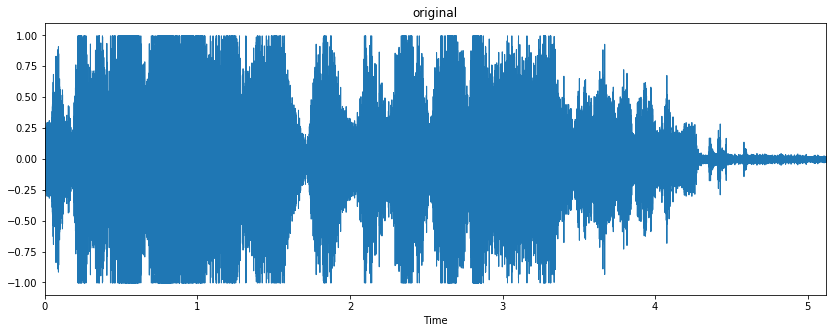

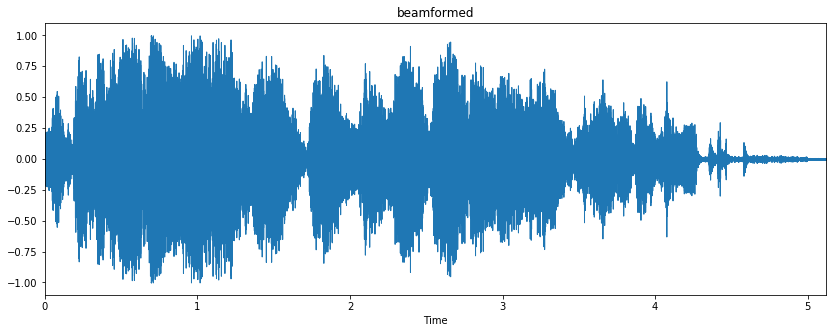

In [4]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('original')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(bf, sr=sr)
plt.title('beamformed')

In [5]:
S = librosa.stft(x, hop_length=32)
print(S.shape)

Sbf = librosa.stft(bf, hop_length=32)
print(Sbf.shape)

(1025, 1281)
(1025, 1281)


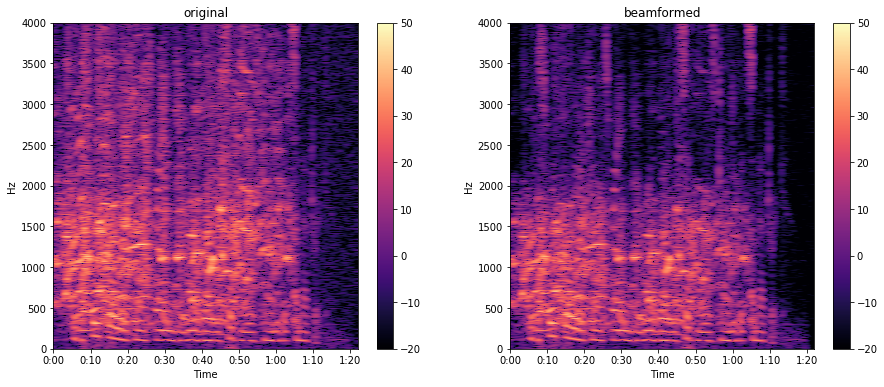

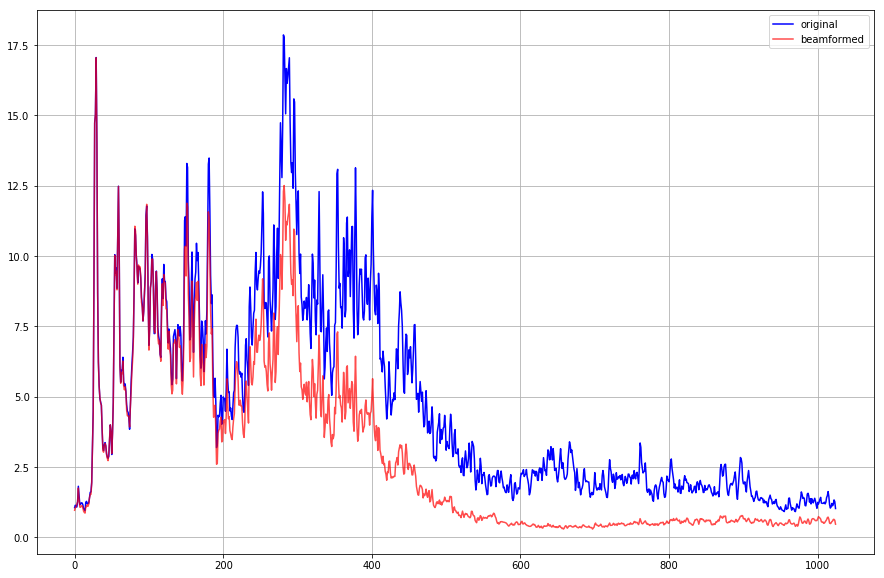

In [6]:
Smag = librosa.magphase(S)[0]
Smagbf = librosa.magphase(Sbf)[0]

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Smag), sr=sr, x_axis='time', y_axis='linear')
plt.title('original')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-20, 50);

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(Smagbf), sr=sr, x_axis='time', y_axis='linear')
plt.title('beamformed')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-20, 50);

plt.figure(figsize=(15, 10))
plt.plot(np.average(Smag, 1), 'b')
plt.plot(np.average(Smagbf, 1), 'r', alpha=0.7)
plt.legend(('original', 'beamformed'))
plt.grid(1)


In [7]:
print(np.average(Smag), np.average(Smagbf))

Smag = Smag/np.average(Smag)
Smagbf = Smagbf/np.average(Smagbf)

print(np.max(Smag), np.max(Smagbf))

4.6074753 2.8931048
35.450623 41.8753


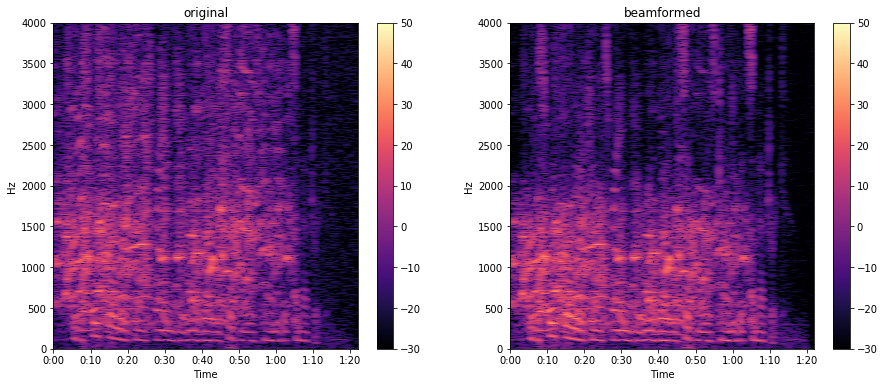

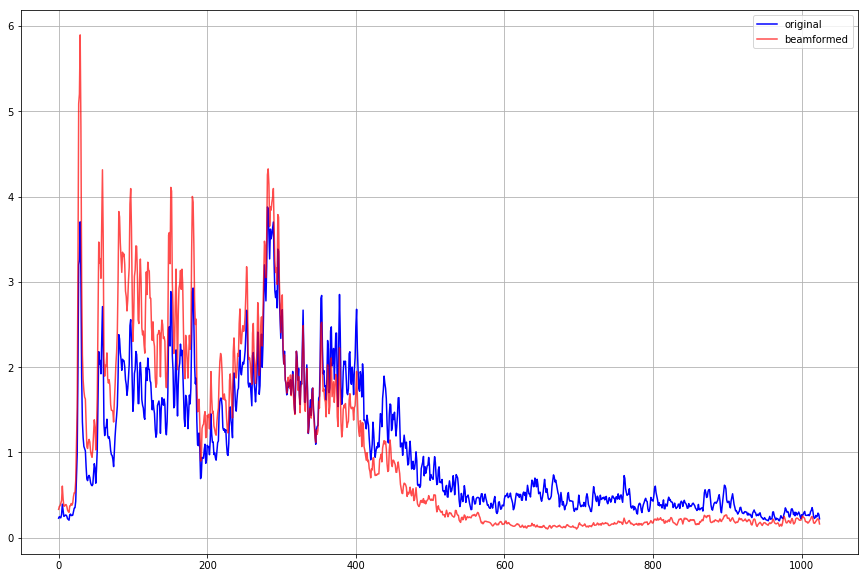

In [8]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Smag), sr=sr, x_axis='time', y_axis='linear')
plt.title('original')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-30, 50);

plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(Smagbf), sr=sr, x_axis='time', y_axis='linear')
plt.title('beamformed')
plt.colorbar()
plt.set_cmap('magma')
plt.clim(-30, 50);

plt.figure(figsize=(15, 10))
plt.plot(np.average(Smag, 1), 'b')
plt.plot(np.average(Smagbf, 1), 'r', alpha=0.7)
plt.legend(('original', 'beamformed'))
plt.grid(1)

#plt.figure(figsize=(15, 10))
#plt.plot(np.average(Smag, 1) - np.average(Smagbf, 1), 'b')
#plt.legend(('original', 'beamformed'))
#plt.grid(1)

In [9]:
n_components = 2048
W, H = librosa.decompose.decompose(Smagbf, n_components=n_components, sort=True)
print(W.shape)
print(H.shape)

(1025, 2048)
(2048, 1281)


Text(0.5,1,'Frequency atoms')

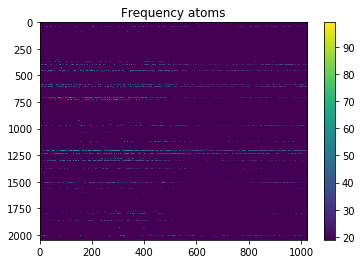

In [10]:
Wmag = librosa.amplitude_to_db(W)
plt.imshow(np.swapaxes(Wmag, 0, 1), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Frequency atoms')

Text(0.5,1,'weights')

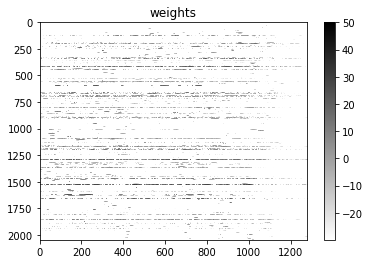

In [11]:
plt.imshow(librosa.amplitude_to_db(H), cmap='gray_r', aspect='auto')
plt.colorbar()
plt.title('weights')

(1025, 1281)


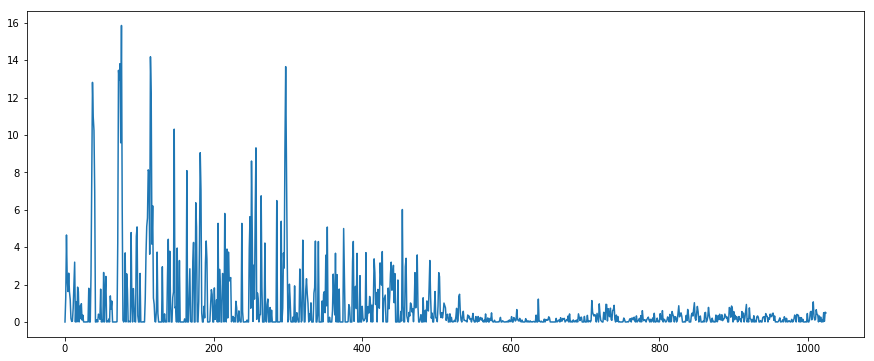

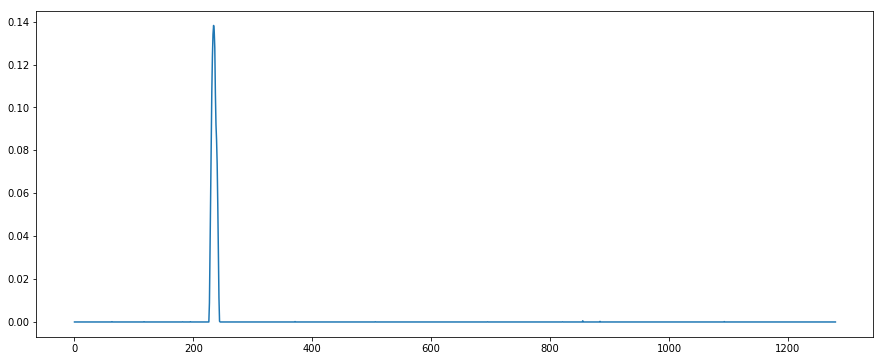

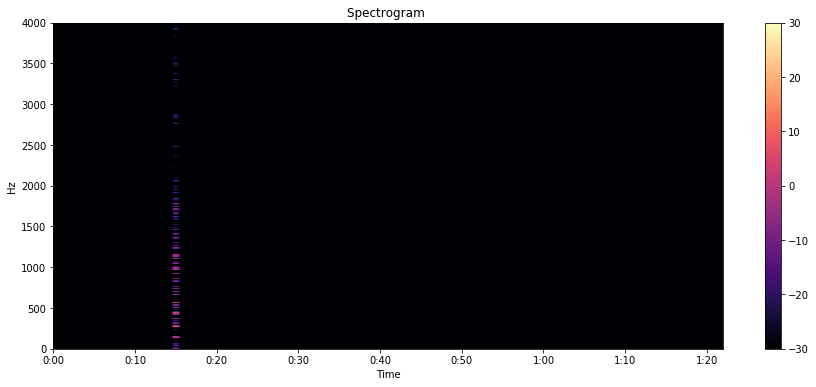

In [12]:
atomSelection = 390

plt.figure(figsize=(15, 6))
plt.plot(W[:,atomSelection])
plt.figure(figsize=(15, 6))
plt.plot(H[atomSelection,:])

atom1mask = W[:,atomSelection].reshape((W[:,1].shape[0], 1))*H[atomSelection,:]
print(atom1mask.shape)

plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(atom1mask), sr=sr, x_axis='time', y_axis='linear')
plt.title('Spectrogram ')
plt.colorbar()
plt.clim(-30, 30);

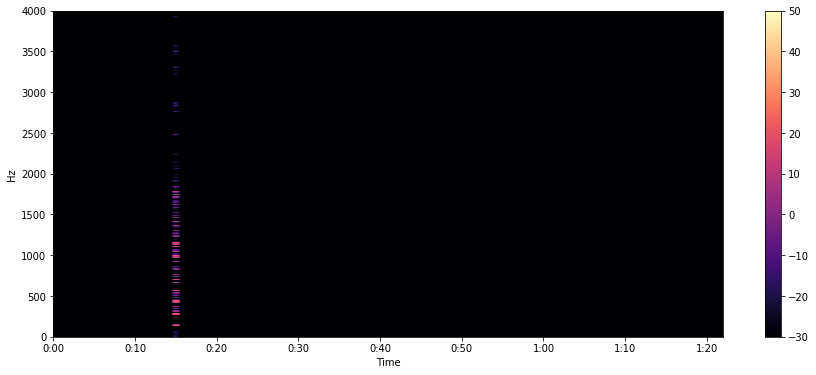

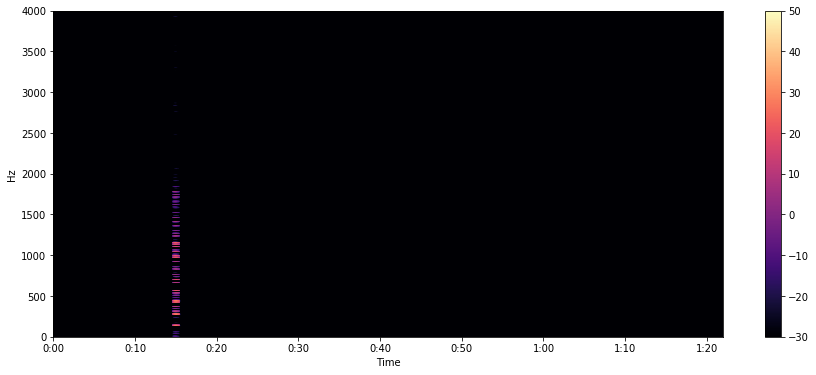

In [13]:
resultmag = np.multiply(Smag, atom1mask)
plt.figure(figsize=(15, 6))
#resultmag = librosa.magphase(result)[0]
librosa.display.specshow(librosa.amplitude_to_db(resultmag), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

resultmagbf = np.multiply(Smagbf, atom1mask)
plt.figure(figsize=(15, 6))
#resultmagbf = librosa.magphase(resultbf)[0]
librosa.display.specshow(librosa.amplitude_to_db(resultmagbf), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

Original :  4.785609640155717
Beamformed :  6.189220011396391


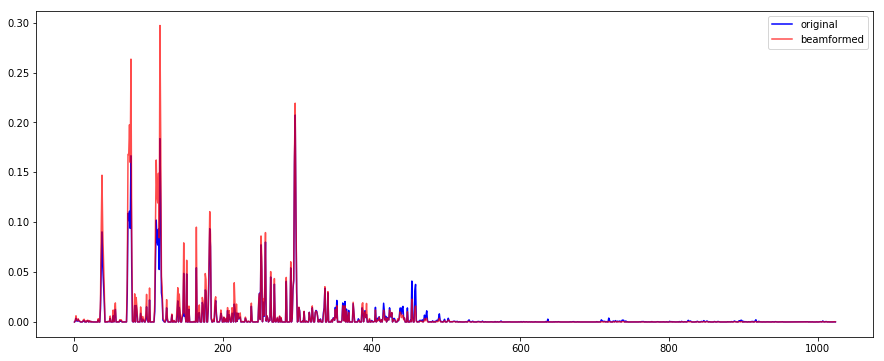

In [14]:
avg = np.average(resultmag, 1)
avgbf = np.average(resultmagbf, 1)

plt.figure(figsize=(15, 6))
plt.plot(avg, 'b')
plt.plot(avgbf, 'r', alpha=0.7)
plt.legend(('original', 'beamformed'))

instant = np.argmax(H[atomSelection,:])

power = np.sum(avg)
power2 = np.sum(librosa.magphase(S[:, instant])[0])
powerbf = np.sum(avgbf)
power2bf = np.sum(librosa.magphase(Sbf[:, instant])[0])

print('Original : ', power)
print('Beamformed : ', powerbf)

In [15]:
mask = np.zeros(n_components)
for i in range(n_components):
    atom1mask = W[:,i].reshape((W[:,1].shape[0], 1))*H[i,:]
    resultmag = np.multiply(Smag, atom1mask)
    resultmagbf = np.multiply(Smagbf, atom1mask)
    avg = np.average(resultmag, 1)
    avgbf = np.average(resultmagbf, 1)
    if(np.sum(avgbf) > np.sum(avg)):
        mask[i] = 1;

In [16]:
print(mask)

[0. 0. 1. ... 1. 0. 1.]


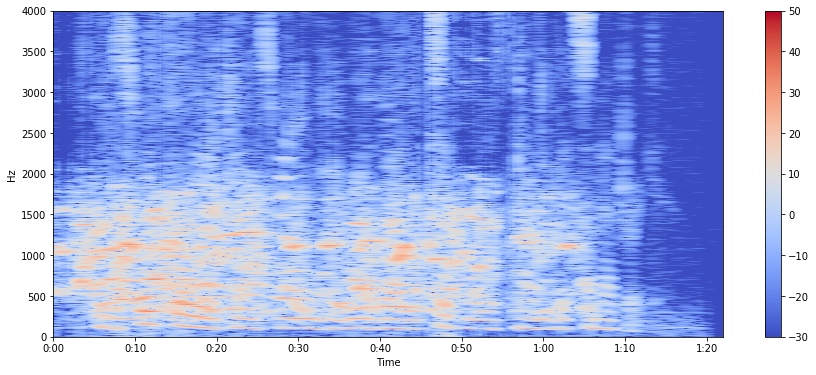

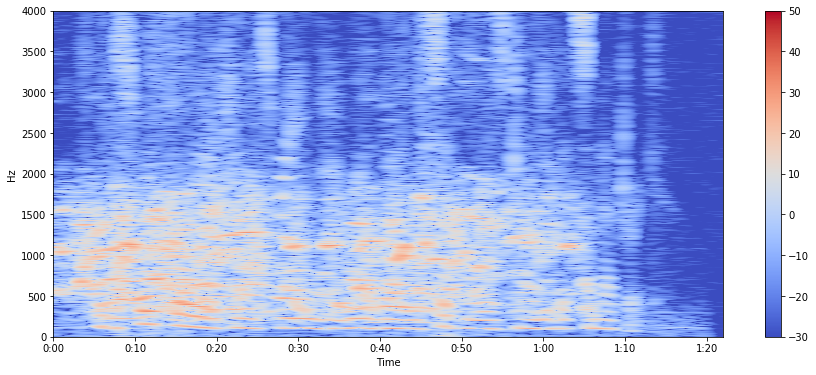

In [17]:
sourcemag = np.zeros(Smag.shape)
for i in range(n_components):
    if(mask[i]):
        sourcemag = sourcemag + sp.outer(W[:,i], H[i])
        
        
# PLOTTING
plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(sourcemag), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);
plt.figure(figsize=(15, 6))
librosa.display.specshow(librosa.amplitude_to_db(Smagbf), sr=sr, x_axis='time', y_axis='linear')
plt.colorbar()
plt.clim(-30, 50);

In [18]:
reconstructed_signal = sp.zeros(len(x))
Y = sourcemag*np.exp(1j*np.angle(Sbf))
y = librosa.istft(Y, hop_length=32)

reconstructed_signal[:len(y)] += y
reconstructed_signal.resize(y.shape)

voice_dft, sr = librosa.load('media/dft_voice_8kHz.wav', sr=None)
voice_cleanspeech, sr = librosa.load('media/cleanspeech_voice_8kHz.wav', sr=None)
voice_laugh, sr = librosa.load('media/laughter_8kHz.wav', sr=None)

voice_laugh = 2*voice_laugh

voice_dft.resize(y.shape)
voice_cleanspeech.resize(y.shape)
voice_laugh.resize(y.shape)

ipd.display( ipd.Audio(bf, rate=sr) )
ipd.display( ipd.Audio(reconstructed_signal, rate=sr) )

noisePwr = 1e-4
snrBefore = librosa.power_to_db(np.average((voice_cleanspeech+voice_laugh)**2+noisePwr)/
                                np.average((bf - voice_dft)**2))
snrAfter = librosa.power_to_db(np.average((voice_cleanspeech+voice_laugh)**2+noisePwr)/
                                np.average((reconstructed_signal - voice_dft)**2))

print('before : ', snrBefore)
print('after : ', snrAfter)

before :  4.013451873014153
after :  9.279602291388052


In [19]:
#from matplotlib.collections import LineCollection
#from matplotlib.ticker import MultipleLocator
#
#fig = plt.figure("MRI_with_EEG",figsize=(10, 80))
#(numSamples, numRows) = H.shape
#t = 10.0 * np.arange(numSamples) / numSamples
#ticklocs = []
#ax2 = fig.add_subplot(2, 2, 1)
#ax2.set_xlim(0, 10)
#ax2.set_xticks(np.arange(10))
#dmin = H.min()
#dmax = H.max()
#dr = (dmax - dmin) * 0.7  # Crowd them a bit.
#y0 = dmin
#y1 = (numRows - 1) * dr + dmax
#ax2.set_ylim(y0, y1)
#
#segs = []
#for i in range(numRows):
#    segs.append(np.hstack((t[:, np.newaxis], H[:, i, np.newaxis])))
#    ticklocs.append(i * dr)
#
#offsets = np.zeros((numRows, 2), dtype=float)
#offsets[:, 1] = ticklocs
#
#lines = LineCollection(segs, offsets=offsets, transOffset=None)
#ax2.add_collection(lines)
#
## Set the yticks to use axes coordinates on the y axis
#ax2.set_yticks(ticklocs)
#
#ax2.set_xlabel('Time (s)')
#
#
##plt.tight_layout()
#plt.show()